# 1.Импорт модулей и анализируемых данных.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from itertools import combinations #для функции проверки статистической значимости get_stat_dif
from scipy.stats import ttest_ind #для get_stat_dif
from datetime import datetime #для анализа дат
from sklearn.preprocessing import  QuantileTransformer # для обработки num_cols
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.metrics import auc, roc_auc_score, roc_curve 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import confusion_matrix, log_loss 


In [2]:
RANDOM_SEED = 42 

In [3]:
'''DATA_DIR = '/kaggle/input/sf-dst-scoring/'
# тренировочный (train, используется для обучения модели)
df_train = pd.read_csv(DATA_DIR+'/train.csv')
# тестовый (test, используется для оценки точности модели)
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')'''

"DATA_DIR = '/kaggle/input/sf-dst-scoring/'\n# тренировочный (train, используется для обучения модели)\ndf_train = pd.read_csv(DATA_DIR+'/train.csv')\n# тестовый (test, используется для оценки точности модели)\ndf_test = pd.read_csv(DATA_DIR+'test.csv')\nsample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')"

In [4]:
!pip freeze > requirements.txt

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# 2. Подготовка функций для анализа

In [6]:
# Функция для поиска выбросов через квантили.
def func_quantile(df, col):   
    
    IQR = df[col].quantile(q=0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    # Подсчитаем количество выбросов
    print("Количество выбросов в столбце",col,":",df[df[col]<perc25 - 1.5*IQR][col].count() + df[df[col]>perc75 + 1.5*IQR][col].count())
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 20, label = 'IQR')
    plt.legend()  

In [7]:
#Функция для заполнения выбросов ближайшим квантилем (с проверкой)
def filling_quantile(df, col):
    
    IQR = df[col].quantile(q=0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    
    high_border = perc75 + 1.5*IQR
    low_border = perc25 - 1.5*IQR
    

    df[col] = df[col].apply(lambda x: high_border if x>high_border else x)
    df[col] = df[col].apply(lambda x: low_border if x<low_border else x)
    func_quantile(df, col)  

In [8]:
# Функция для первичного анализа
def primary_analysis(df, column):
    df[column] = df[column].apply(lambda column: None if column == '' else None if pd.isnull(column) else None if column == 'nan' 
                            else None if column == 'NaN'  else None if column == 'Nan'
                            else column)
    a = df[column].value_counts()
    b = df.loc[:, [column]].info()
    c = df[column].unique()
    d = df[column].describe()
    e = sns.countplot(x=column,data=df)
    return a, b, c, d

# Функция для построения графика boxplot
def get_boxplot(df, column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, data=df,ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [9]:
def get_stat_dif(df, column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'default'], 
                        df.loc[df.loc[:, column] == comb[1], 'default']).pvalue \
            <= 0.05/len(combinations_all): # Поправка Бонферрони
            print('Найдены статистически значимые различия для колонки', column)
            break

# 3. Просмотр даных

In [11]:
df_train.head(1)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0


In [12]:
df_train.shape

(73799, 19)

In [13]:
df_train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [14]:
df_test.head(1)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N


In [15]:
df_test.shape

(36349, 18)

In [16]:
df_test.columns # отсутствует колонка 'default'

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport'],
      dtype='object')

In [17]:
# для дальнейшей обработки признаков объединяем  в один датасет df_train и df_test
df_train['sample']  = 1   # новый признак
df_test['sample']   = 0    
df_test['default'] = -1   # колонка 'default' отсутствует, заполняем произвольно (-1 чтобы не совпадало с имеющимися значениями)
data = pd.concat([df_train, df_test], ignore_index=True)

In [18]:
data.shape

(110148, 20)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [20]:
data.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,sample
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,-0.244916,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.595908,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,-1.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,-1.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


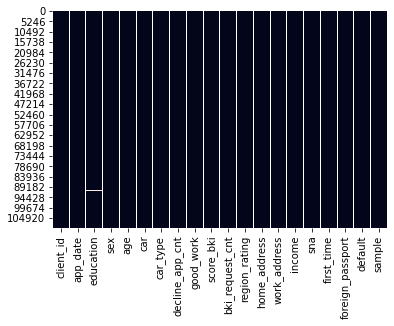

In [21]:
sns_heatmap = sns.heatmap(data.isnull(), cbar=False) #есть пропуск только в графе 'education'

## 3.1. Обогащение данных 

In [22]:
# средние доходы по возрастным группам
mean_income = data.groupby('age')['income'].mean().to_dict()
data['mean_income_age'] = data['age'].map(mean_income)
# максимальные доходы по возрастным группам
max_income = data.groupby('age')['income'].max().to_dict()
data['max_income_age'] = data['age'].map(max_income)
# норма доходов по возрастным группам
data["normalized_income"] = abs((data.income - data.mean_income_age)/data.max_income_age)
# BKI по возрастным группам
mean_bki = data.groupby('age')['bki_request_cnt'].mean().to_dict()
data['mean_requests_age'] = data['age'].map(mean_bki)

In [23]:
#бинарные переменные
bin_cols=['sex','car','car_type','good_work','foreign_passport']

#категориальные переменные
cat_cols=['education','home_address','work_address','app_date','sna'] 

#числовые переменные
num_cols=['age','decline_app_cnt','income','bki_request_cnt','score_bki','region_rating','first_time','mean_income_age',
         'max_income_age', 'normalized_income', 'mean_requests_age']

In [24]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,sample,mean_income_age,max_income_age,normalized_income,mean_requests_age
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,...,18000,4,1,N,0,1,28025.405650,300000,0.033418,2.020339
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,...,19000,4,1,N,0,1,29799.811194,950000,0.011368,2.074627
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,...,30000,1,4,Y,0,1,35853.015188,600000,0.009755,1.793135
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,...,10000,1,3,N,0,1,42983.164141,1000000,0.032983,2.172727
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,...,30000,1,4,Y,0,1,46150.815259,900000,0.017945,2.216411


# 4.Работа с колонками

## 4.1.'default' (целевая переменная)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   default  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.7 KB


( 0    64427
 -1    36349
  1     9372
 Name: default, dtype: int64,
 None,
 array([ 0,  1, -1], dtype=int64),
 count    110148.000000
 mean         -0.244916
 std           0.595908
 min          -1.000000
 25%          -1.000000
 50%           0.000000
 75%           0.000000
 max           1.000000
 Name: default, dtype: float64)

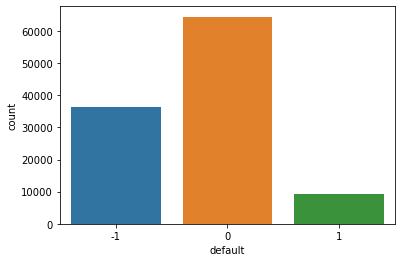

In [25]:
 primary_analysis(data, 'default')

In [26]:
count = data[data['default']!=-1]['default'].value_counts(normalize=False)
n_samples= count[0] + count[1]

weight_0 = round(n_samples/count[0],2)
weight_1 = round(n_samples/count[1],2)
weights = {0:weight_0, 1:weight_1}
weights

{0: 1.15, 1: 7.87}

## 4.2. Числовые переменные (num_cols)


'Оценка значимости переменных через однофакторный дисперсионный анализ (ANOVA)\nНаибольшая значимость у признака score_bki'

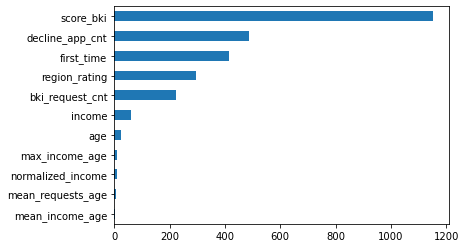

In [27]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
'''Оценка значимости переменных через однофакторный дисперсионный анализ (ANOVA)
Наибольшая значимость у признака score_bki'''

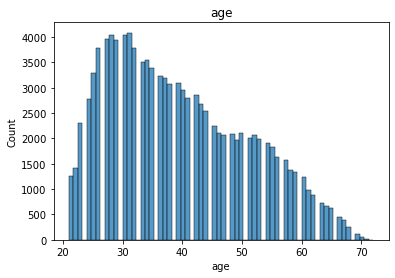

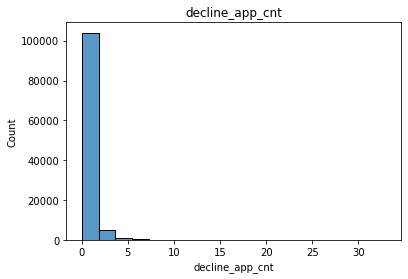

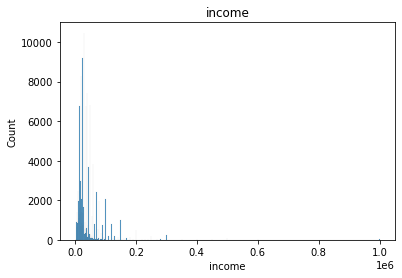

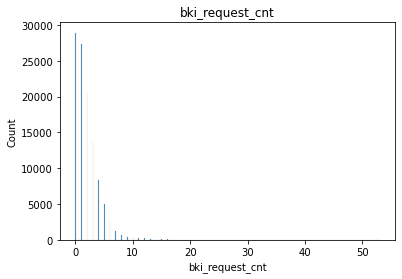

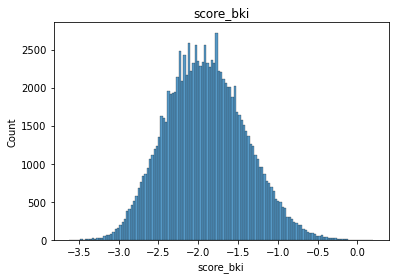

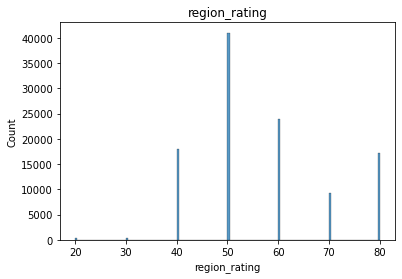

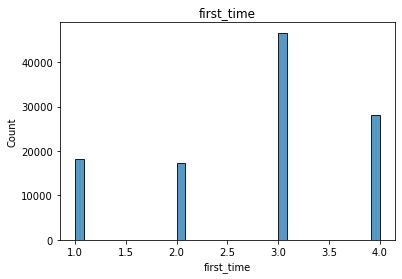

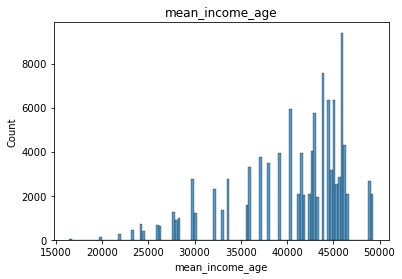

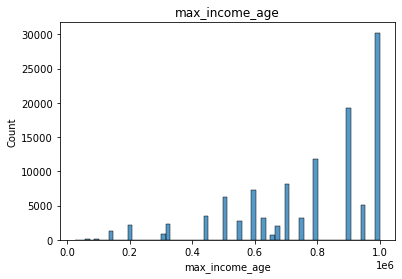

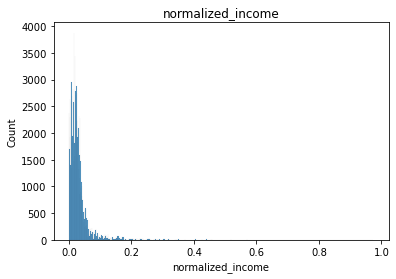

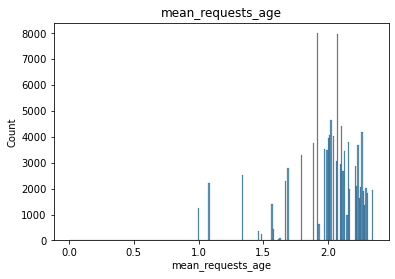

In [28]:
for i in num_cols:
    plt.figure()
    sns.histplot(data[i], kde = False)
    plt.title(i)
    plt.show()

# 4.2.2 'age'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   age     110148 non-null  int64
dtypes: int64(1)
memory usage: 860.7 KB


(31    4084
 28    4035
 30    4035
 27    3964
 29    3940
 26    3780
 32    3773
 34    3548
 33    3499
 35    3386
 25    3292
 36    3228
 37    3185
 39    3095
 38    3070
 40    2950
 42    2857
 41    2804
 24    2780
 43    2672
 44    2536
 23    2295
 45    2235
 50    2104
 46    2102
 48    2084
 47    2074
 52    2065
 51    2015
 53    1980
 49    1964
 54    1911
 55    1837
 56    1641
 57    1578
 22    1415
 58    1373
 59    1340
 21    1262
 60    1236
 61     975
 62     885
 63     720
 64     663
 65     618
 66     442
 67     382
 68     261
 69     110
 70      60
 71       6
 72       2
 Name: age, dtype: int64,
 None,
 array([62, 59, 25, 53, 48, 27, 39, 50, 54, 29, 32, 30, 23, 37, 36, 41, 28,
        58, 26, 45, 44, 43, 56, 40, 34, 33, 67, 38, 46, 42, 35, 24, 61, 21,
        52, 55, 49, 57, 31, 64, 63, 51, 22, 65, 47, 66, 68, 60, 69, 70, 72,
        71], dtype=int64),
 count    110148.000000
 mean         39.249410
 std          11.518063
 min          21

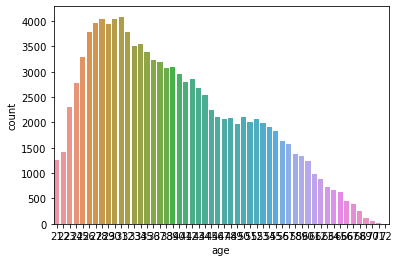

In [29]:
primary_analysis(data, 'age')

25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].
Количество выбросов в столбце age : 0


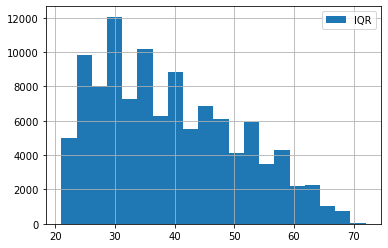

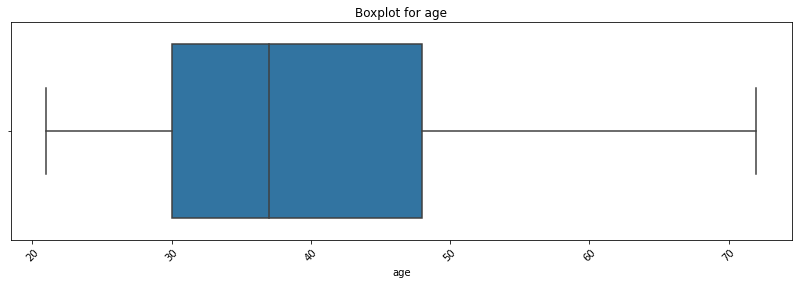

In [30]:
func_quantile(data, 'age')
get_boxplot(data, 'age')

In [31]:
#Проверка корреляции
data.loc[:,'default'].astype('float64').corr(data.loc[:,'age']).astype('float64')
#Корреляция практически отсутствует

-0.005926681179673848

# 4.2.3. 'decline_app_cnt'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   decline_app_cnt  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.7 KB


(0     91471
 1     12500
 2      3622
 3      1365
 4       606
 5       255
 6       156
 7        58
 8        37
 9        29
 10       16
 11       10
 12        5
 13        4
 14        3
 16        3
 30        1
 15        1
 19        1
 20        1
 21        1
 22        1
 24        1
 33        1
 Name: decline_app_cnt, dtype: int64,
 None,
 array([ 0,  2,  1,  3,  4,  6,  5,  7,  8,  9, 13, 11, 19, 10, 22, 33, 14,
        12, 15, 24, 16, 21, 30, 20], dtype=int64),
 count    110148.000000
 mean          0.273205
 std           0.799099
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max          33.000000
 Name: decline_app_cnt, dtype: float64)

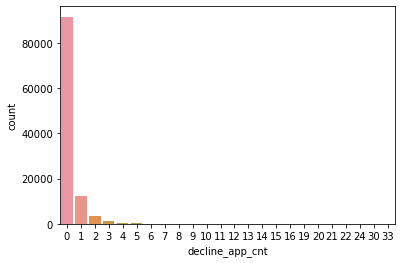

In [32]:
primary_analysis(data, 'decline_app_cnt')

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Количество выбросов в столбце decline_app_cnt : 18677


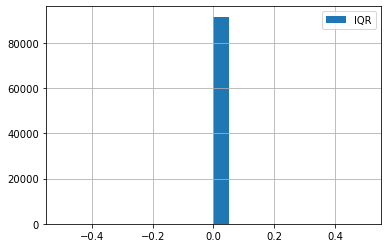

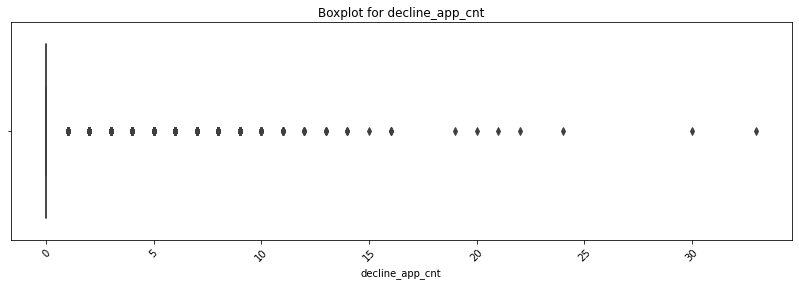

In [33]:
func_quantile(data, 'decline_app_cnt')
get_boxplot(data, 'decline_app_cnt')

In [34]:
data.groupby('default')['decline_app_cnt'].mean()
# Дефолтные клиенты (1) в среднем имеют большое количество отмененных заявок. Заменять значения не требуется

default
-1    0.268040
 0    0.240877
 1    0.515472
Name: decline_app_cnt, dtype: float64

In [35]:
#Проверка корреляции
data.loc[:,'default'].astype('float64').corr(data.loc[:,'decline_app_cnt']).astype('float64')
#Корреляция практически отсутствует

0.046867768770311145

## 4.2.4. 'income'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   income  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.7 KB


(30000     10437
 25000      9090
 20000      8174
 40000      7383
 50000      6742
           ...  
 27478         1
 27350         1
 20412         1
 23120         1
 426000        1
 Name: income, Length: 1207, dtype: int64,
 None,
 array([ 18000,  19000,  30000, ...,   7350, 274000,   6020], dtype=int64),
 count     110148.000000
 mean       41012.648537
 std        45399.735051
 min         1000.000000
 25%        20000.000000
 50%        30000.000000
 75%        48000.000000
 max      1000000.000000
 Name: income, dtype: float64)

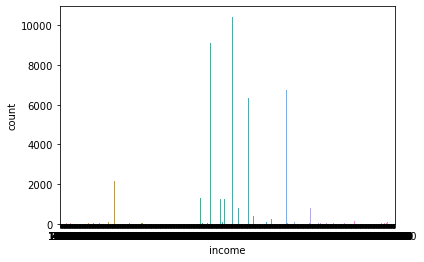

In [36]:
primary_analysis(data, 'income')

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Количество выбросов в столбце income : 7000


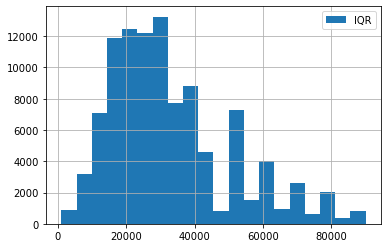

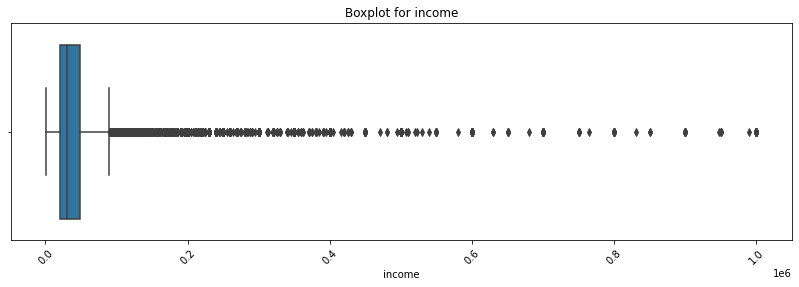

In [37]:
func_quantile(data, 'income')
get_boxplot(data, 'income')

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Количество выбросов в столбце income : 0


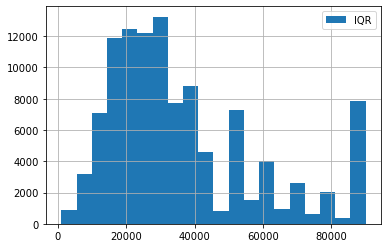

In [38]:
filling_quantile(data,'income') # замена выбросов

In [39]:
#Проверка корреляции
data.loc[:,'default'].astype('float64').corr(data.loc[:,'income']).astype('float64')
#Корреляция практически отсутствует

-0.022869539565615125

## 4.2.5. 'bki_request_cnt'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   bki_request_cnt  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.7 KB


(0     28908
 1     27295
 2     20481
 3     13670
 4      8406
 5      4960
 6      2500
 7      1292
 8       735
 9       459
 10      350
 11      278
 12      217
 13      151
 14      110
 15       81
 16       58
 17       33
 18       32
 19       30
 21       19
 20       14
 23       12
 24       12
 22        8
 25        5
 27        5
 28        5
 26        4
 32        4
 29        3
 33        2
 40        2
 41        1
 46        1
 45        1
 47        1
 36        1
 34        1
 53        1
 Name: bki_request_cnt, dtype: int64,
 None,
 array([ 1,  3,  2,  0,  4,  7,  5,  8,  6, 13, 10, 22, 12, 11, 34,  9, 16,
        14, 26, 21, 18, 24, 15, 19, 32, 17, 20, 23, 27, 36, 53, 25, 45, 33,
        28, 41, 29, 46, 47, 40], dtype=int64),
 count    110148.000000
 mean          2.005002
 std           2.266926
 min           0.000000
 25%           0.000000
 50%           1.000000
 75%           3.000000
 max          53.000000
 Name: bki_request_cnt, dtype: float64)

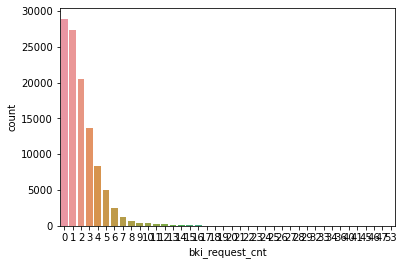

In [40]:
primary_analysis(data, 'bki_request_cnt')

25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Количество выбросов в столбце bki_request_cnt : 2636


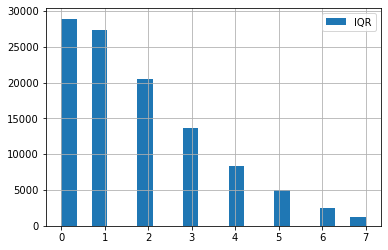

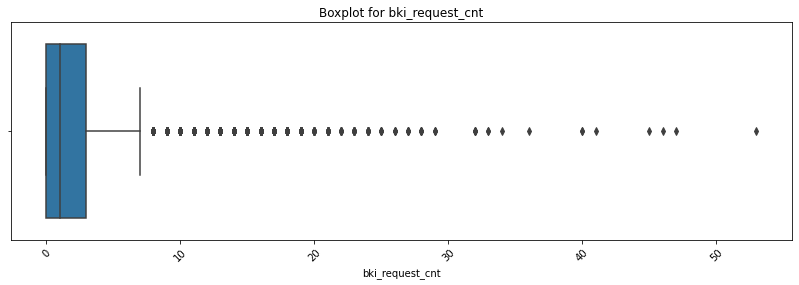

In [41]:
func_quantile(data, 'bki_request_cnt')
get_boxplot(data, 'bki_request_cnt')

25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Количество выбросов в столбце bki_request_cnt : 0


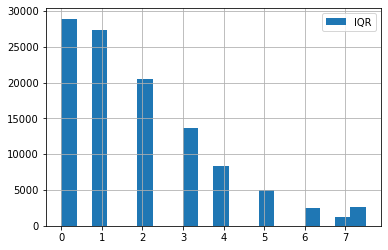

In [42]:
filling_quantile(data,'bki_request_cnt')

## 4.2.6. Остальные колонки

In [43]:
for i in num_cols:
    features = data[[i]].values
    norm_features = (features - features.mean(axis=0)) / features.std(axis=0)
    data.loc[:, [i]] = norm_features

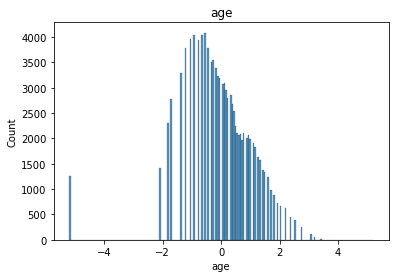

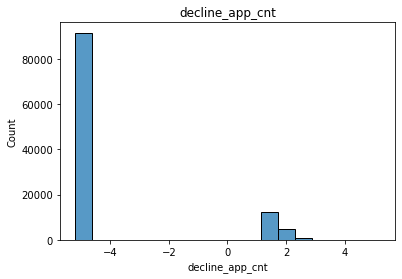

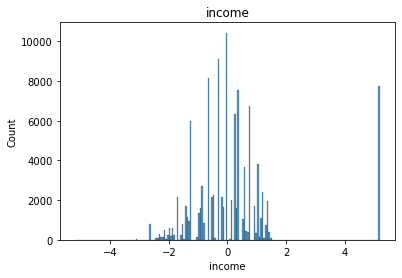

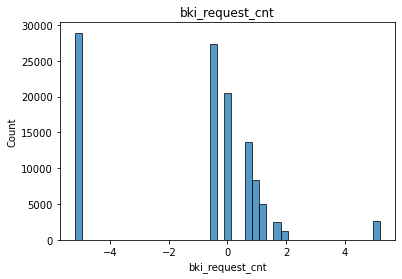

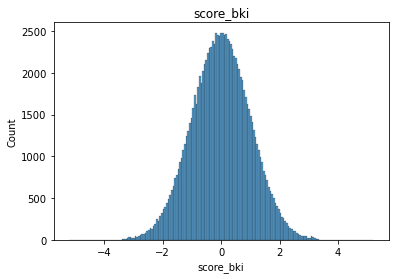

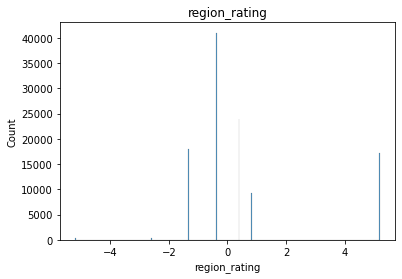

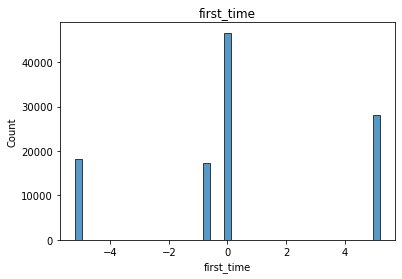

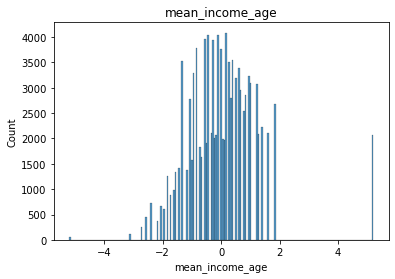

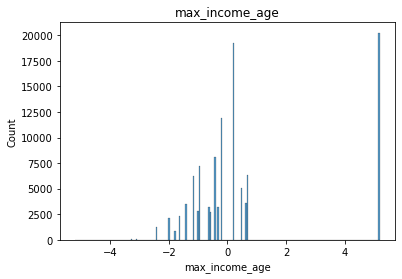

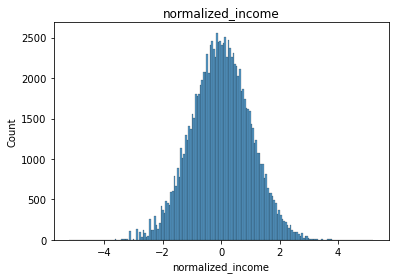

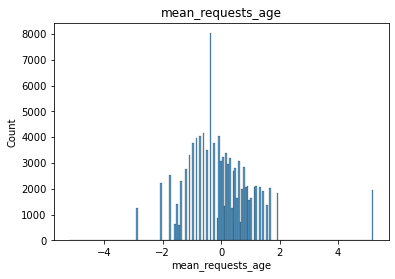

'Отображение в гауссово распределение'

In [44]:
for i in num_cols:
    quantile_transformer = QuantileTransformer(output_distribution='normal')
    new = quantile_transformer.fit_transform(data.loc[:,i].values.reshape(-1,1))
    data[[i]] = new
    plt.figure()
    sns.histplot(data[i], kde = False)
    plt.title(i)
    plt.show()
'''Отображение в гауссово распределение'''

'Корреляция в пределах нормы (не более 0.56)'

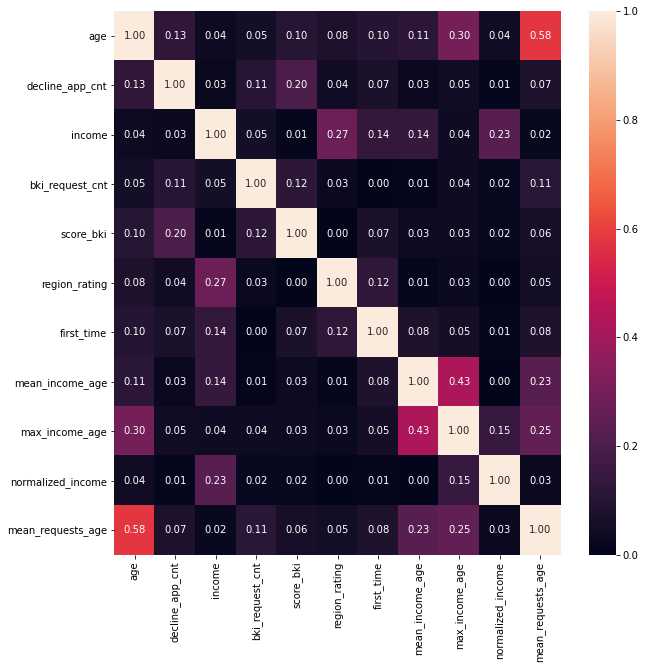

In [45]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1,annot=True, fmt=".2f",)
'''Корреляция в пределах нормы (не более 0.56)'''

## 4.3. cat_cols

In [46]:
cat_cols

['education', 'home_address', 'work_address', 'app_date', 'sna']

## 4.3.1. 'education'

In [47]:
display(data['education'].unique())
data['education'].value_counts()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan], dtype=object)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

<AxesSubplot:>

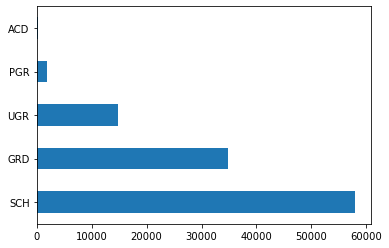

In [48]:
data['education'].value_counts().plot.barh()

In [49]:
# Заполним наиболее частым значением
data = data.fillna('SCH')

## 4.3.2. 'home_address'

In [50]:
display(data['home_address'].unique())
data['home_address'].value_counts()

array([1, 2, 3], dtype=int64)

2    59591
1    48688
3     1869
Name: home_address, dtype: int64

## 4.3.3. 'work_address'

In [51]:
display(data['work_address'].unique())
data['work_address'].value_counts()

array([2, 3, 1], dtype=int64)

3    67113
2    30761
1    12274
Name: work_address, dtype: int64

## 4.3.4. 'app_date'

In [52]:
#Преобразуем 
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_date'] = data['app_date'].apply(lambda x: x.month)

#добавим после преобразования эту колонку в num_cols и исключим из cat_cols
num_cols.append('app_date')
cat_cols.remove('app_date')

In [53]:
cat_cols

['education', 'home_address', 'work_address', 'sna']

## 4.3.5. 'sna'

In [54]:
display(data['sna'].unique())
data['sna'].value_counts()

array([4, 1, 2, 3], dtype=int64)

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

## 4.3.6. Encoding 

In [55]:
cat_encode = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
cat_encode

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [56]:
cat_encode.shape

(110148, 15)

In [57]:
label_encoder = LabelEncoder()
data['education'] = label_encoder.fit_transform(data['education'])

## 4.4. bin_cols (LabelEncoder)

In [58]:
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [59]:
 data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,sample,mean_income_age,max_income_age,normalized_income,mean_requests_age
0,25905,2,3,1,1.831224,1,1,-5.199338,0,-0.162309,...,-0.857097,4,-5.199338,0,0,1,-1.700222,-1.792374,0.617938,-0.146048
1,63161,3,3,0,1.494155,0,0,-5.199338,0,0.742066,...,-0.798769,4,-5.199338,0,0,1,-1.558482,0.493553,-0.694008,0.116941
2,25887,2,3,1,-1.368450,1,0,1.750222,0,0.977883,...,-0.008782,1,5.199338,1,0,1,-0.965420,-0.926176,-0.774833,-1.081940
3,16222,1,3,0,1.016672,0,0,-5.199338,0,-0.260222,...,-1.679303,1,0.085414,0,0,1,0.060256,5.199338,0.601334,0.700711
4,101655,4,1,1,0.683178,0,0,-5.199338,1,1.281224,...,-0.008782,1,5.199338,1,0,1,1.283836,0.232930,-0.270485,0.851675


## 4.4.1. Проверка значимости признаков

<AxesSubplot:>

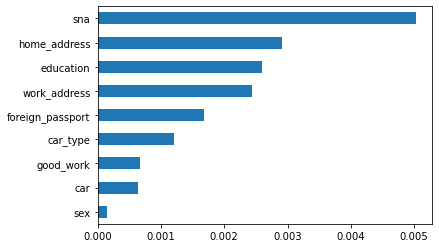

In [60]:
imp = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp.sort_values(inplace = True)
imp.plot(kind = 'barh')

<AxesSubplot:>

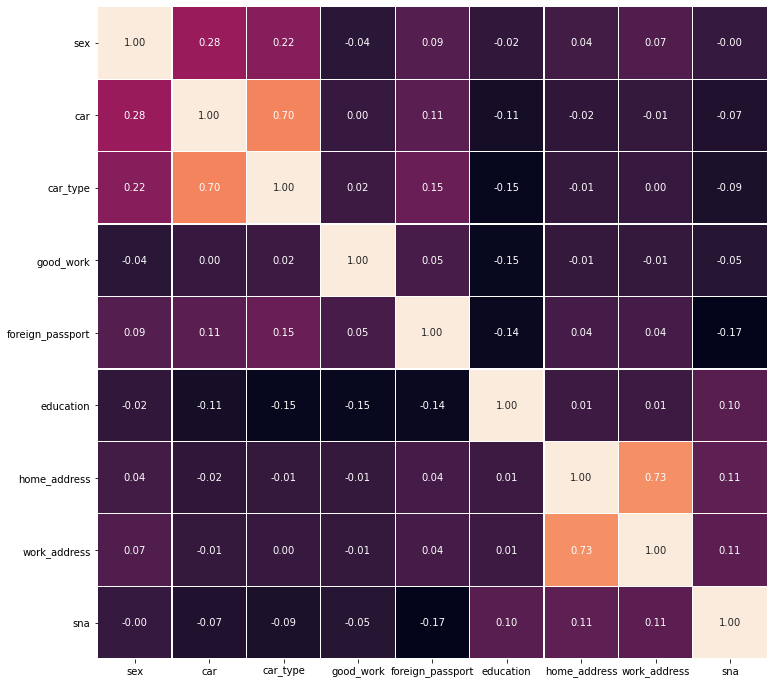

In [61]:
plt.rcParams['figure.figsize'] = (12,12)
sns.heatmap(data[bin_cols + cat_cols ].corr(),annot=True, fmt=".2f", linewidths=0.1, cbar=False)

<AxesSubplot:>

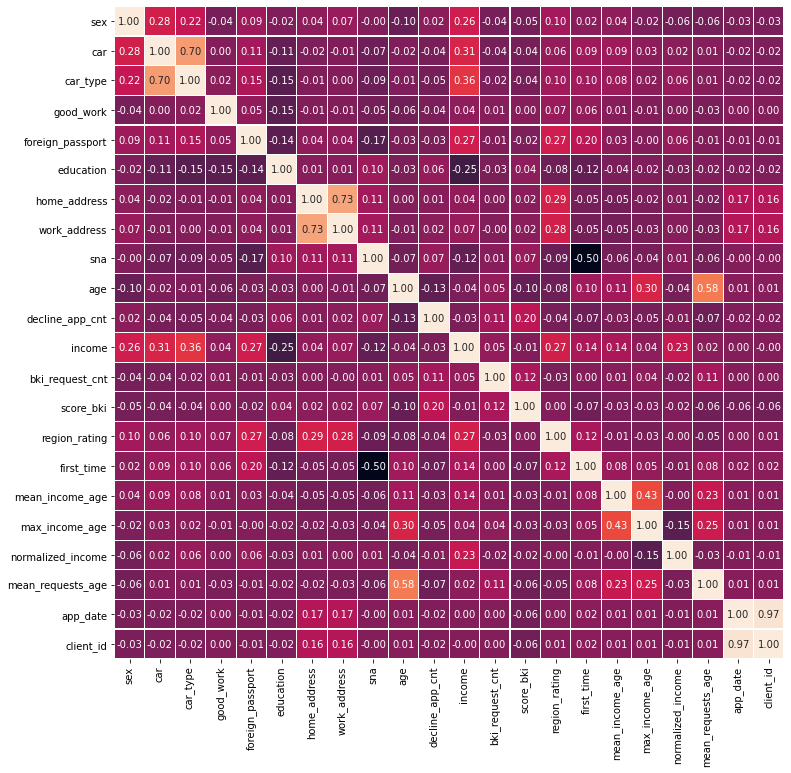

In [62]:
plt.rcParams['figure.figsize'] = (12,12)
sns.heatmap(data[bin_cols + cat_cols + num_cols +['client_id']].corr(),annot=True, fmt=".2f", linewidths=0.1, cbar=False)

Сильная корреляция наблюдается между:

'car', 'car_type' - (0.70). 'car' слабее коррелирует с целевой переменной. Объединю и  исключаю.

'work_address' и 'home_address' - (0.73). 'work_address' слабее коррелирует с целевой переменной. Объединю и исключаю.

'client_id' и 'app_date'  - (0.97). Уберу 'client_id'.

In [63]:
data['cars'] = data['car'] + data['car_type']
data['address'] = data['work_address'] + data['home_address']
data.drop(['car', 'car_type', 'work_address', 'home_address'], inplace=True, axis=1)

Значимая корреляция наблюдается между:

'first_time' и 'sna' - (-0.5). 

'mean_requests_age' и 'age' - (0.56)

На основе этих признаков создадим полиномиальные признаки.

In [64]:
pf = PolynomialFeatures(2)
p1_features = pf.fit_transform(data[['first_time','sna']])
p1_features.shape

(110148, 6)

In [65]:
p2_features = pf.fit_transform(data[['mean_requests_age','age']])
p2_features.shape

(110148, 6)

In [66]:
df = pd.DataFrame(p1_features,columns = ['p1','p2','p3','p4','p5','p6'])
df_2 = pd.DataFrame(p2_features,columns = ['p7','p8','p9','p10','p11','p12'])                  

In [67]:
data['p1'] =df['p1']
data['p2'] =df['p2']
data['p3'] =df['p3']
data['p4'] =df['p4']
data['p5'] =df['p5']
data['p6'] =df['p6']
data['p7'] =df_2['p7']
data['p8'] =df_2['p8']
data['p9'] =df_2['p9']
data['p10'] =df_2['p10']
data['p11'] =df_2['p11']
data['p12'] =df_2['p12']

In [68]:
for x in data:
    get_stat_dif(data,x)

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning

Найдены статистически значимые различия для колонки app_date
Найдены статистически значимые различия для колонки education
Найдены статистически значимые различия для колонки decline_app_cnt
Найдены статистически значимые различия для колонки good_work
Найдены статистически значимые различия для колонки bki_request_cnt
Найдены статистически значимые различия для колонки region_rating
Найдены статистически значимые различия для колонки income
Найдены статистически значимые различия для колонки sna
Найдены статистически значимые различия для колонки first_time
Найдены статистически значимые различия для колонки foreign_passport
Найдены статистически значимые различия для колонки default
Найдены статистически значимые различия для колонки sample
Найдены статистически значимые различия для колонки cars
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки p2
Найдены статистически значимые различия для колонки p3
Найдены статистическ

In [69]:
data_final = data[['client_id','app_date', 'education', 'decline_app_cnt', 'good_work', 'bki_request_cnt', 'region_rating', 'income', 'sna', 
                  'first_time', 'foreign_passport', 'default', 'sample', 'p2', 'p3', 'p4', 'p5', 'p6', 'cars', 'address']]

In [70]:
data_final.head()

,client_id,app_date,education,decline_app_cnt,good_work,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,default,sample,p2,p3,p4,p5,p6,cars,address
0,25905,2,3,-5.199338,0,-0.545244,-0.370902,-0.857097,4,-5.199338,0,0,1,-5.199338,4.0,27.033111,-20.797350,16.0,2,3
1,63161,3,3,-5.199338,0,0.700711,-0.370902,-0.798769,4,-5.199338,0,0,1,-5.199338,4.0,27.033111,-20.797350,16.0,0,5
2,25887,2,3,1.750222,0,-0.545244,5.199338,-0.008782,1,5.199338,1,0,1,5.199338,1.0,27.033111,5.199338,1.0,1,3
3,16222,1,3,-5.199338,0,0.033880,-0.370902,-1.679303,1,0.085414,0,0,1,0.085414,1.0,0.007296,0.085414,1.0,0,5
4,101655,4,1,-5.199338,1,-0.545244,0.385726,-0.008782,1,5.199338,1,0,1,5.199338,1.0,27.033111,5.199338,1.0,0,5


## 5. Модель

In [71]:
data_work = data_final.copy()

In [72]:
train_1 = data_work.query('sample == 1').drop(['sample'], axis=1)
test_1 = data_work.query('sample == 0').drop(['sample'], axis=1)

In [73]:
train = train_1.drop(['client_id'], axis=1)
test = test_1.drop(['client_id'], axis=1)

In [74]:
# Разделим данные для обучения 
X = train.drop(['default',],axis=1).values
y = train.default

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

'''Лучшее Penalty: l2
Лучшее C: 2.7825594022071245'''

In [75]:
model = LogisticRegression(max_iter=1000, class_weight=weights, C=2.7825594022071245)
model.fit(X_train, y_train)

LogisticRegression(C=2.7825594022071245, class_weight={0: 1.15, 1: 7.87},
                   max_iter=1000)

In [76]:
val_predicted = model.predict(X_val)
val_predicted_prob = model.predict_proba(X_val)

accuracy_score: 0.6382113821138211
precision_score: 0.20294266869609334
recall_score: 0.6568144499178982
f1_score: 0.3100775193798449

confusion matrix: 
 [[8220 4713]
 [ 627 1200]]

Предсказано невозращение кредита клиентом, по факту вернувшим кредит: 4713 
 или 36.44% от всех вернувших 

Предсказан возврат кредита клиентом, по факту не вернувшим кредит: 627 
или 34.32% от всех не вернувших


roc_auc_score: 0.7014597484886002


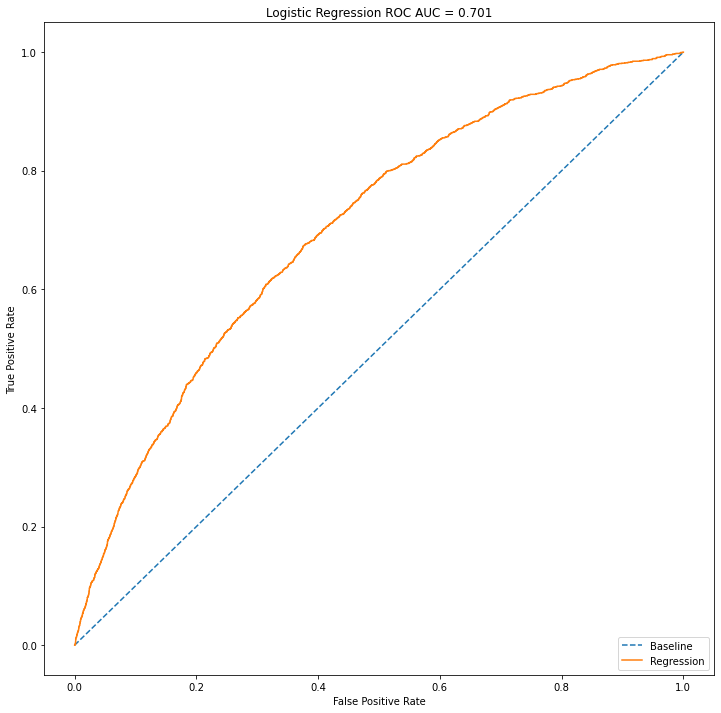

In [77]:
print('accuracy_score:', accuracy_score(y_val, val_predicted))
print('precision_score:', precision_score(y_val, val_predicted))
print('recall_score:', recall_score(y_val, val_predicted))
print('f1_score:', f1_score(y_val, val_predicted))
сf_mtx = confusion_matrix(y_val, val_predicted)
print()
print('confusion matrix:', '\n', сf_mtx)
tn, fp, fn, tp = сf_mtx.ravel()
print()
print('Предсказано невозращение кредита клиентом, по факту вернувшим кредит: {} \n\
 или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))
print('Предсказан возврат кредита клиентом, по факту не вернувшим кредит: {} \n\
или {}% от всех не вернувших\n'.format(fn, 
                                        round((1-recall_score(y_val,
                                                              val_predicted))*100, 2)))
print()
print('roc_auc_score:', roc_auc_score(y_val, val_predicted_prob[:, 1]))
fpr, tpr, threshold = roc_curve(y_val, val_predicted_prob[:, 1])
roc_auc = roc_auc_score(y_val, val_predicted_prob[:, 1])
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

## 6. Результаты

In [78]:
test.shape

(36349, 18)

In [88]:
test_pred = test.drop(['default'],axis=1).values
prediction_target = model.predict_proba(test_pred)[:, 1]
submission = pd.DataFrame(data=test_1['client_id'], columns=['client_id'])
submission.index = np.arange(len(submission))
prediction_target =pd.DataFrame(data=prediction_target, columns=['default'])
submission['default'] = prediction_target['default']

In [90]:
submission.to_csv('submission.csv', index=False)
submission.shape

(36349, 2)

In [84]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          36349 non-null  int64  
 1   prediction_target  36349 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 851.9 KB
